# Does Political Structure Influence Voter Turnout in Industrialized Democracy?

### STAT 301 - Group Project - Proposal

In [51]:
# Load the necessary packages for the Project Proposal
library(GGally)
library(dplyr)
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(faux)
library(leaps)
library(car)
library(mltools)

## 1. Introduction

The two competing explanations for differences in voter turnout between countries in the literature is either cultural or institution-based. The cultural argument traditionally cites Almond and Verba’s (1963) work that turnout depends on the unique, participatory culture of each country. Alternatively, the classic work by Jackman (1987) suggests the structure of a country’s political institutions has a “major and predictable” impact on voting rates regardless of cultural differences (p. 406). However, Jackson’s shortcoming was he could only compare 19 countries in the 1970s. Thus his results might not be generalizable to all elections and industrialized democracies. Subsequent studies mostly focused on country-specific elections but have cast doubt on whether institutional factors have an effect (Freitag, 2010). This study, therefore, aims to test Jackson’s claims that voter turnout is majorly impacted by the structure of political institutions in industrialized democracies by using a more comprehensive and updated dataset.

The QOG dataset will be from the Quality of Government Institute, where researchers compiled measures for each country from hundreds of sources (Teorell et. al., 2022). The dataset has information from 1960 to 2018 for the 36 OECD and EU democracies, however, after cleaning the data, 35 country observations remain. We base our methods on Jackman (1987), and will build a regression of the voter turnout against institutional measures of electoral competitiveness, multipartyism, electoral proportionality, and whether the legislature is bicameral.

We estimate institutionalized competition using Vanhanen (2019)’s method based on the percentage of votes that go to small parties, multipartyism by the number of influential parties, electoral proportionality on a dummy whether proportional representation systems exist, and bicameralism (the presence of two legislatures) using a dummy with 0 for unitary and 1 for bicameral governments.

The dataset can be found at: https://www.qogdata.pol.gu.se/data/codebook_std_jan22.pdf

## 2. Data Wrangling and Cleaning

### 2.1 Importing the Dataset

In [2]:
url <- "https://www.qogdata.pol.gu.se/data/qog_std_ts_jan22.csv"
QOG_dataset_original <- read_delim(url, ",")

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 15168 Columns: 1913
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (7): cname, cname_qog, ccodealp, version, cname_year, ccodealp_year, ...
dbl (1903): ccode, year, ccode_qog, ccodecow, aid_cpnc, aid_cpsc, aid_crnc, ...
lgl    (3): psi_cpsi2, psi_edate2, psi_psi2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2.2 Cleaning the Dataset

In [19]:
# For cleaning up the dataset we will be doing the following:.
# - We will be renaming our selected variables for better readability.
# - We will be filtering out the NA rows when applicable.

QOG_cleaned <- QOG_dataset_original %>% 
                select(cname, van_part, van_comp, jw_bicameral, br_pvote, cpds_enpv, 
                      vdem_egal, vdem_gender, vdem_gcrrpt, vdem_execorr) 

colnames(QOG_cleaned) <- c("country", "voter_turnout", "elec_comp", "gov_type", "prop_rep", "num_party",
                           "index_ega", "index_woman", "index_legis", "index_exe")

QOG_cleaned <- QOG_cleaned %>%
                mutate(gov_type = ifelse(is.na(gov_type), 0, gov_type)) %>%
                mutate(gov_type = ifelse(gov_type == 0, "unitary", "bicaremel")) %>%
                mutate(prop_rep = ifelse(prop_rep == 0, "no", "yes")) %>%
                filter(country != is.na(country),
                       voter_turnout != is.na(voter_turnout),
                       elec_comp != is.na(elec_comp),
                       gov_type != is.na(gov_type),
                       prop_rep != is.na(prop_rep),
                       num_party != is.na(num_party),
                       index_ega != is.na(index_ega),
                       index_woman != is.na(index_woman),
                       index_legis != is.na(index_legis),
                       index_exe != is.na(index_exe))

head(QOG_cleaned)

country,voter_turnout,elec_comp,gov_type,prop_rep,num_party,index_ega,index_woman,index_legis,index_exe
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Australia,51.0,57.1,unitary,no,2.973527,0.787,0.600,3.071,0.072
Australia,51.1,52.0,unitary,no,2.814222,0.787,0.600,3.071,0.072
Australia,50.1,52.0,unitary,no,2.814222,0.787,0.602,3.071,0.072
Australia,50.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072
Australia,50.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072
Australia,51.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072


In [20]:
unique(QOG_cleaned$gov_type)

[1] "unitary"   "bicaremel"

In [21]:
unique(QOG_cleaned$prop_rep)

[1] "no"  "yes"

In [22]:
head(QOG_cleaned)

country,voter_turnout,elec_comp,gov_type,prop_rep,num_party,index_ega,index_woman,index_legis,index_exe
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Australia,51.0,57.1,unitary,no,2.973527,0.787,0.600,3.071,0.072
Australia,51.1,52.0,unitary,no,2.814222,0.787,0.600,3.071,0.072
Australia,50.1,52.0,unitary,no,2.814222,0.787,0.602,3.071,0.072
Australia,50.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072
Australia,50.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072
Australia,51.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072


In [23]:
QOG_cleaned$gov_type <- as.factor(QOG_cleaned$gov_type)
QOG_cleaned$prop_rep <- as.factor(QOG_cleaned$prop_rep)

In [24]:
levels(QOG_cleaned$prop_rep)

[1] "no"  "yes"

***[THING TO DO]: What is the proportion of the missing data? Do you know the missingness mechanism?***

## 3. Methodology and Results

### 3.1 Summary Tables

We will be building summary tables just to see the averages for the data, by country, government type, and whether there is a proportional representation or not.

**Table 1: Summary of the Data by Country**

In [9]:
QOG_by_country <- QOG_cleaned %>% select(-gov_type, -prop_rep) %>%
                    group_by(country) %>%
                    summarize(avg_voter_turnout = mean(voter_turnout),
                              avg_elec_comp = mean(elec_comp),
                              avg_num_party = mean(num_party))
head(QOG_by_country)

country,avg_voter_turnout,avg_elec_comp,avg_num_party
<chr>,<dbl>,<dbl>,<dbl>
Australia,58.09051,57.47119,3.078265
Austria,61.09593,58.54407,3.167171
Belgium,60.26864,68.20339,7.853640
Bulgaria,53.35724,54.97000,4.442549
Canada,44.63186,58.11695,3.312809
Croatia,54.46421,51.51158,5.927319


The response variable, the percentage of voter turnout, mostly ranges from 40% to 65% when categorized by country. The two explanatory variables are percentage of votes that go to small parties and of multipartyism by the number of influential parties, the first avergae of which is around 55% and the second of which is aound 4%. 

**Table 2: Summary of the Data by Government Type**

In [10]:
QOG_by_gov_type <- QOG_cleaned %>% select(-country, -prop_rep) %>%
                    group_by(gov_type) %>%
                    summarize(avg_voter_turnout = mean(voter_turnout),
                              avg_elec_comp = mean(elec_comp),
                              avg_num_party = mean(num_party))
QOG_by_gov_type

gov_type,avg_voter_turnout,avg_elec_comp,avg_num_party
<fct>,<dbl>,<dbl>,<dbl>
bicaremel,53.91845,59.76825,4.378209


The mean voter turnout for the unitary government type is 5% lower than that for bicaremelism while the percentage of votes that go to small parties and of multipartyism by the number of influential parties are basically the same for both types.

**Table 3: Summary of the Data by whether there is proportional representation or not**

In [11]:
QOG_by_prop_rep <- QOG_cleaned %>% select(-country, -gov_type) %>%
                    group_by(prop_rep) %>%
                    summarize(avg_voter_turnout = mean(voter_turnout),
                              avg_elec_comp = mean(elec_comp),
                              avg_num_party = mean(num_party))
QOG_by_prop_rep

prop_rep,avg_voter_turnout,avg_elec_comp,avg_num_party
<fct>,<dbl>,<dbl>,<dbl>
yes,53.91845,59.76825,4.378209


For a country with proportional representation systems, the average turn out is 5% higher than the country without proportional representation systems. Consistently, the percentage of votes that go to small parties and of multipartyism by the number of influential parties for a country with proportional representation systems are respectively 4% higher and 1% higher than the countries without ones.

### 3.2 Preliminary Results and Visualizations

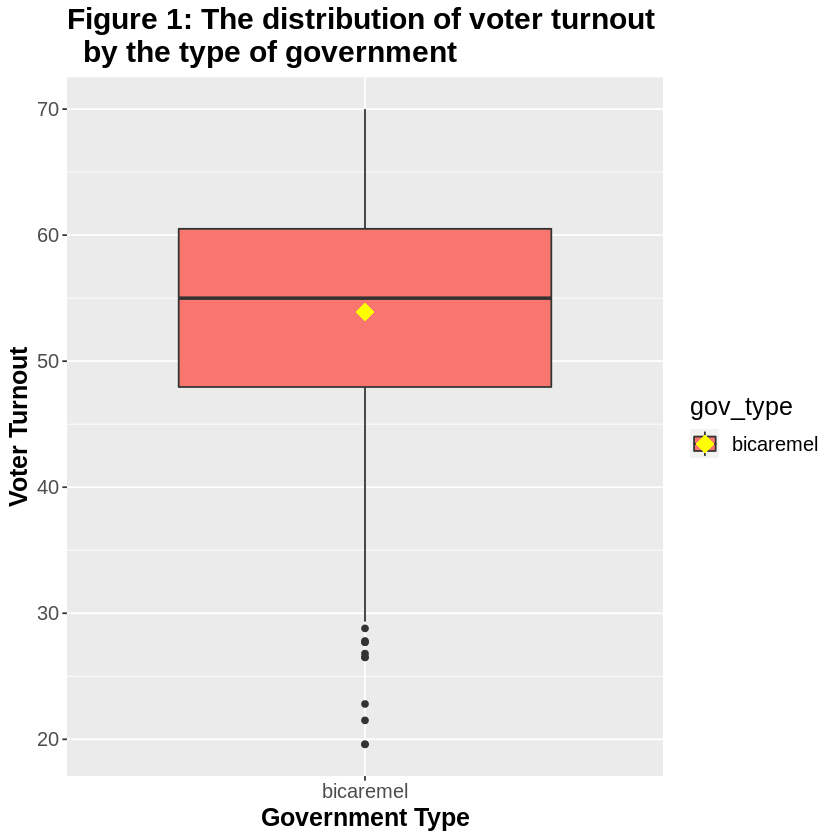

In [12]:
gov_type_boxplots <- QOG_cleaned %>%
  ggplot() +
  geom_boxplot(aes(gov_type, voter_turnout, fill = gov_type)) +
  theme(
    text = element_text(size = 12),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("Figure 1: The distribution of voter turnout 
  by the type of government") +
  theme(text = element_text(size = 15)) +
  xlab("Government Type") +
  ylab("Voter Turnout") +
  stat_summary(aes(gov_type, voter_turnout, fill = gov_type),
    fun = mean, colour = "yellow", geom = "point",
    shape = 18, size = 5
  )

gov_type_boxplots

The mean voter turnout for the unitary government type is 5% lower than that for bicaremelism, however, the variance is larger for unitary than that for bicaremelism. We can also see that there are more outliers for the unitary government type.

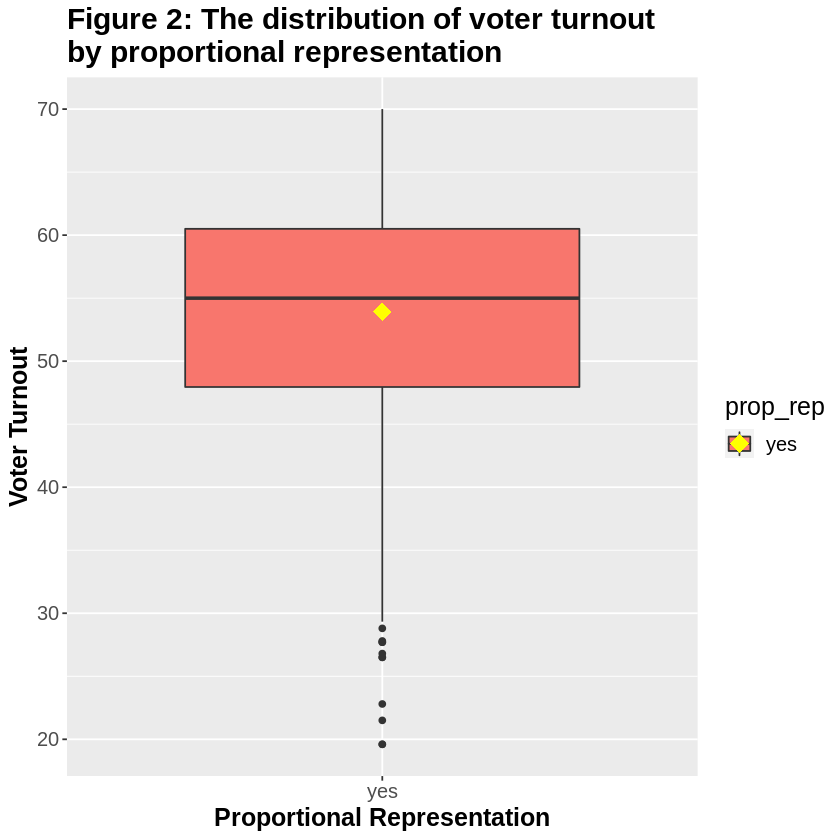

In [13]:
prop_rep_boxplots <- QOG_cleaned %>%
    ggplot() +
    geom_boxplot(aes(prop_rep, voter_turnout, fill = prop_rep)) +
    theme(
      text = element_text(size = 11),
      plot.title = element_text(face = "bold"),
      axis.title = element_text(face = "bold")
    ) +
    ggtitle("Figure 2: The distribution of voter turnout 
by proportional representation") +
    theme(text = element_text(size = 15)) +
    xlab("Proportional Representation") +
    ylab("Voter Turnout") +
    stat_summary(aes(prop_rep, voter_turnout, fill = prop_rep),
      fun = mean, colour = "yellow", geom = "point",
      shape = 18, size = 5
    )

prop_rep_boxplots

We can see that the mean for yes is 7% higher than the mean for no, with similar variances for both.

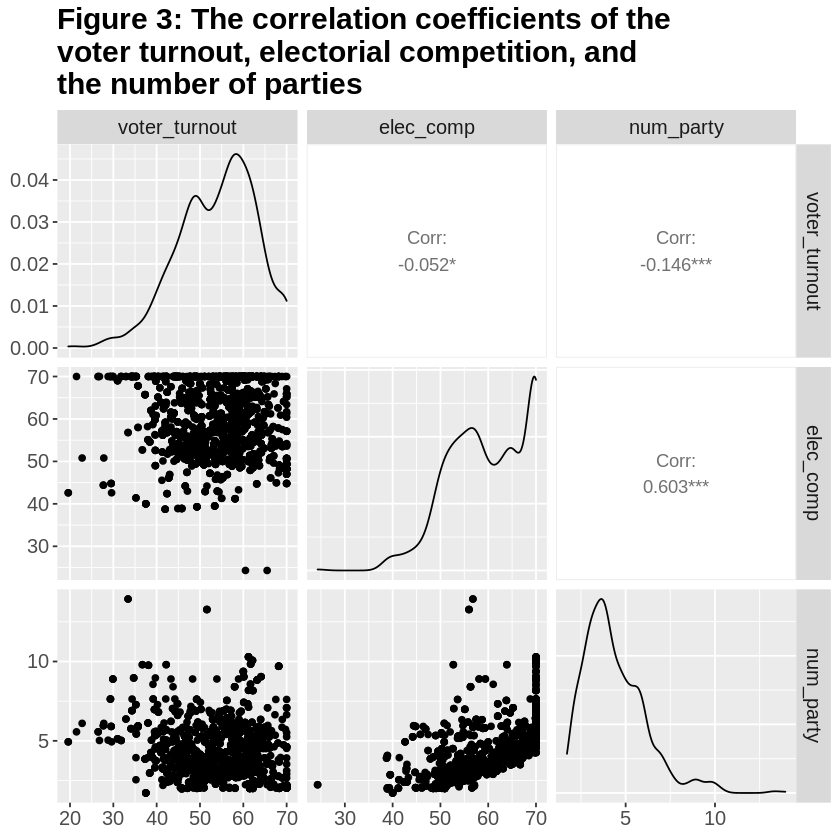

In [14]:
QOG_cleaned_pairplots <- QOG_cleaned %>%
    select(voter_turnout, elec_comp, num_party) %>%
    ggpairs(progress = FALSE) +
    theme(
      text = element_text(size = 20),
      plot.title = element_text(face = "bold"),
      axis.title = element_text(face = "bold")
    ) +
    ggtitle("Figure 3: The correlation coefficients of the
voter turnout, electorial competition, and 
the number of parties") +
    theme(text = element_text(size = 15))

QOG_cleaned_pairplots

**Voter Turnout vs. Electoral Competition:** There is a very weak negative relationship between these two variables, which corresponds to the distracted scatterplot.

**Voter Turnout vs. Effective Number of Parties:** This graph shows a weak negative relationship between the two variables, though, with the center of 4 effective parties and 55% of the participation rates, the plot is still scattered.

The main reason for this particular correlation graph is that our dataset accounts for voter data from a vast time period and a vast selection of countries with differing political landscapes, government structures, etc.

### 3.3 Spliting Data

In [25]:
QOG_cleaned$ID <- 1:nrow(QOG_cleaned)
selection_QOG <- sample_n(QOG_cleaned, size = nrow(QOG_cleaned) * 0.3,
                        replace = FALSE)
model_QOG <- anti_join(QOG_cleaned, 
                        selection_QOG,
                        by = "ID")
training_QOG <- sample_n(model_QOG, size = nrow(model_QOG) * 0.7,
                        replace = FALSE)
testing_QOG <- anti_join(model_QOG, 
                        training_QOG,
                        by = "ID")
selection_QOG <- selection_QOG %>% select(-"ID")
training_QOG <- training_QOG %>% select(-"ID")
testing_QOG <- testing_QOG %>% select(-"ID")

In [26]:
head(training_QOG)

country,voter_turnout,elec_comp,gov_type,prop_rep,num_party,index_ega,index_woman,index_legis,index_exe
<chr>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Australia,61.70,66.60,unitary,no,3.605969,0.857,0.936,3.073,0.032
Luxembourg,42.43,66.32,unitary,yes,4.812690,0.956,0.883,3.770,0.012
Greece,66.50,53.10,unitary,yes,2.633818,0.906,0.888,2.516,0.284
Germany,54.58,58.36,unitary,yes,4.824974,0.944,0.955,3.403,0.008
Estonia,42.30,70.00,unitary,yes,5.031092,0.884,0.929,3.136,0.041
Finland,53.70,70.00,unitary,yes,5.645252,0.936,0.951,3.419,0.021


### 3.4 Model Construction (Jackman)

In [27]:
old_model <- lm(voter_turnout ~ elec_comp + gov_type + prop_rep + num_party, data = training_QOG)
summary(old_model)


Call:
lm(formula = voter_turnout ~ elec_comp + gov_type + prop_rep + 
    num_party, data = training_QOG)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.026  -5.535   0.370   5.539  20.258 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     54.06861    2.39341  22.591  < 2e-16 ***
elec_comp        0.05432    0.04676   1.162    0.246    
gov_typeunitary -3.59157    0.68498  -5.243 2.01e-07 ***
prop_repyes      6.53665    0.70971   9.210  < 2e-16 ***
num_party       -1.30966    0.21816  -6.003 2.92e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.402 on 810 degrees of freedom
Multiple R-squared:  0.1249,	Adjusted R-squared:  0.1206 
F-statistic: 28.91 on 4 and 810 DF,  p-value: < 2.2e-16


In [28]:
tidy(old_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),54.06861442,2.39340814,22.590637,5.155132e-88
elec_comp,0.05431865,0.04675928,1.161666,2.457135e-01
gov_typeunitary,-3.59156629,0.68498303,-5.243292,2.014425e-07
prop_repyes,6.53665417,0.70970962,9.210322,2.727112e-19
num_party,-1.30966184,0.21815776,-6.003279,2.916337e-09


In [43]:
vif(old_model)

elec_comp  gov_type  prop_rep num_party 
 1.637839  1.036154  1.126004  1.709212

### 3.5 Backwards Selection

In [35]:
turnout_backward_sel <- regsubsets(
  x = voter_turnout ~ elec_comp + gov_type + prop_rep + num_party + index_ega + index_woman+ index_legis + index_exe, nvmax = 8,
  data = selection_QOG,
  method = "backward",
)

summary(turnout_backward_sel)

Subset selection object
Call: regsubsets.formula(x = voter_turnout ~ elec_comp + gov_type + 
    prop_rep + num_party + index_ega + index_woman + index_legis + 
    index_exe, nvmax = 8, data = selection_QOG, method = "backward", 
    )
8 Variables  (and intercept)
                Forced in Forced out
elec_comp           FALSE      FALSE
gov_typeunitary     FALSE      FALSE
prop_repyes         FALSE      FALSE
num_party           FALSE      FALSE
index_ega           FALSE      FALSE
index_woman         FALSE      FALSE
index_legis         FALSE      FALSE
index_exe           FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: backward
         elec_comp gov_typeunitary prop_repyes num_party index_ega index_woman
1  ( 1 ) " "       " "             " "         " "       " "       "*"        
2  ( 1 ) " "       " "             " "         "*"       " "       "*"        
3  ( 1 ) " "       " "             "*"         "*"       " "       "*"        
4  ( 1 ) " "       "*"  

In [36]:
turnout_bwd_summary <- summary(turnout_backward_sel)

turnout_bwd_summary_df <- data.frame(
    n_input_variables = 1:8,
    RSQ = turnout_bwd_summary$rsq,
    RSS = turnout_bwd_summary$rss,
    ADJ.R2 = turnout_bwd_summary$adjr2
)

turnout_bwd_summary_df

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.03485947,38351.57,0.03291363
2,0.09866120,35816.29,0.09501943
3,0.15236162,33682.41,0.14721402
4,0.18798277,32266.94,0.18139440
5,0.20685938,31516.85,0.19879901
6,0.21024430,31382.34,0.20059352
7,0.21323284,31263.59,0.20199331
8,0.21331061,31260.50,0.20044044


Based on the summary of the model selection, we can see that the model with 7 input variables have the best performance in terms of adjusted r2. Considering the fact that adjusted r2 is commonly used to compare models with different sizes, we adopted the model with 7 input variables as the new model.

In [37]:
new_model <- lm(voter_turnout ~ elec_comp + gov_type + prop_rep + num_party + index_ega + index_woman+ index_legis,
               data = training_QOG)
summary(new_model)


Call:
lm(formula = voter_turnout ~ elec_comp + gov_type + prop_rep + 
    num_party + index_ega + index_woman + index_legis, data = training_QOG)

Residuals:
     Min       1Q   Median       3Q      Max 
-28.7369  -4.3994   0.1701   4.8860  19.3218 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     22.72549    4.39599   5.170 2.96e-07 ***
elec_comp       -0.15176    0.04757  -3.190 0.001477 ** 
gov_typeunitary -3.33298    0.65230  -5.110 4.03e-07 ***
prop_repyes      5.35624    0.69551   7.701 3.95e-14 ***
num_party       -1.37148    0.21579  -6.356 3.47e-10 ***
index_ega       24.73789    6.10763   4.050 5.61e-05 ***
index_woman     20.11192    3.46899   5.798 9.65e-09 ***
index_legis      1.95750    0.54026   3.623 0.000309 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.761 on 807 degrees of freedom
Multiple R-squared:  0.256,	Adjusted R-squared:  0.2496 
F-statistic: 39.68 on 7 and 807 DF,  p-

In [38]:
tidy(new_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),22.7254881,4.3959852,5.169601,2.960122e-07
elec_comp,-0.1517552,0.0475704,-3.190119,1.477098e-03
gov_typeunitary,-3.3329823,0.6523010,-5.109577,4.032991e-07
prop_repyes,5.3562388,0.6955100,7.701167,3.947489e-14
num_party,-1.3714753,0.2157869,-6.355693,3.467055e-10
index_ega,24.7378896,6.1076344,4.050323,5.608237e-05
index_woman,20.1119212,3.4689885,5.797633,9.647264e-09
index_legis,1.9574984,0.5402604,3.623250,3.091294e-04


In [52]:
vif(new_model)

elec_comp    gov_type    prop_rep   num_party   index_ega index_woman 
   1.986532    1.101152    1.267277    1.959706    2.162363    1.473501 
index_legis 
   1.802567

### 3.6 Model Comparison

In [39]:
anova(old_model, new_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,810,57179.08,NA,NA,NA,NA
2,807,48611.55,3,8567.536,47.40987,3.167847e-28


The p-value for the F-test is lower than 0.05, so with the confidence level alpha=0.05, new model is significantly better than the old model.

### 3.7 Prediction

In [44]:
pred <- predict(new_model, newdata=testing_QOG)

In [50]:
R_MSE = rmse(
    preds=pred,
    actuals=testing_QOG$voter_turnout)
R_MSE

[1] 7.957918


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


